In [1]:
import re
import glob
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew 
from wordcloud import WordCloud, STOPWORDS 
from graphviz import Digraph
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from heapq import nlargest
import os
os.environ["PATH"] += os.pathsep + 'C:\\graphviz\\bin'

In [2]:
def get_colored_graph(file):
    g = Digraph('G')
    g.attr(size='20')
    with open(file, 'r', encoding="utf8") as f:
        data = json.load(f)
    g.attr('node')
    for key in data:
        score = data[key]['sentiment']
        if(score <= -0.8):
            g.node(key, color='#67001F', style="filled")
        elif(score > -0.8 and score <= -0.6):
            g.node(key, color='#B2172B', style="filled")
        elif(score > -0.6 and score <= -0.4):
            g.node(key, color='#D6604D', style="filled")
        elif(score > -0.4 and score <= -0.2):
            g.node(key, color='#F4A582', style="filled")
        elif(score > -0.2 and score < 0):
            g.node(key, color='#FDDBC7', style="filled")
        elif(score == 0.0):
            g.node(key, color='#F8F8F8', style="filled")
        elif(score > 0.0 and score <= 0.2):
            g.node(key, color='#D1E5F0', style="filled")
        elif(score > 0.2 and score <= 0.4):
            g.node(key, color='#92C5DF', style="filled")
        elif(score > 0.4 and score <= 0.6):
            g.node(key, color='#4393C3', style="filled")
        elif(score > 0.6 and score <= 0.8):
            g.node(key, color='#2166AC', style="filled")
        elif(score > 0.8):
            g.node(key, color='#053061', style="filled")
    for key in data:
        if(key is not None):
            if(data[key]["replie_to"] is not None):
                g.edge(data[key]["replie_to"], key)
    g.view()

In [92]:
def word_cloud(lista, name_file):
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    for each in lista:
        aux = list()
        for item in graphs[each]:
            val = str(graphs[each].nodes[item]['text'])

            # typecaste each val to string 
            val = str(val) 

            val = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', val, flags=re.MULTILINE)

            # split the value 
            tokens = val.split() 

            # Converts each token into lowercase 
            for i in range(len(tokens)): 
                tokens[i] = tokens[i].lower() 

            for words in tokens: 
                comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud)
    _= plt.axis("off") 
    _= plt.tight_layout(pad = 0) 
    _= plt.savefig(name_file, quality = 95, orientation='portrait')

In [4]:
def get_dist_sentiment(lista):
    dist_sentiment = dict()
    all_sentiments = list()
    for each in lista:
        aux = list()
        for item in graphs[each]:
            aux.append(graphs[each].nodes[item]['sentiment'])
            all_sentiments.append(graphs[each].nodes[item]['sentiment'])
        dist_sentiment[each] = np.array(aux)
    positives = dict()
    negatives = dict()
    for i in dist_sentiment:
        k = int(len(dist_sentiment[i])*0.5)
        if(k != 0):
            number = max(nlargest(k, dist_sentiment[i]))
        else:
            number = dist_sentiment[i][0]
        if(number >= 0):
            positives[i] = dist_sentiment[i]
        else:
            negatives[i] = dist_sentiment[i]
    return all_sentiments, dist_sentiment, positives, negatives

In [5]:
def gen_boxplot(distribution_vec, name_file, original):
    # Create a figure instance
    fig = plt.figure(1, figsize=(20, 10))

    # Create an axes instance
    ax = fig.add_subplot(111)
    plt.rc('ytick', labelsize=15) 
    plt.rc('xtick', labelsize=2) 
    
    #Limiar do tweet original
    item = original.split("_")
    item = item[1].split(".")
    item = item[0]
    X = np.linspace(1, len(distribution_vec), len(distribution_vec))
    Y = 0*X + graphs[original].nodes[item]['sentiment']
    plt.plot(X, Y, sns.xkcd_rgb["pale red"], lw=3)
    
    #Eixo 0
    Y0 = 0*X
    plt.plot(X, Y0, sns.xkcd_rgb["blue"], lw=3)
    
    # Create the boxplot
    bp = ax.boxplot(distribution_vec)

    # Save the figure
    _= plt.savefig(name_file, quality = 95, orientation='portrait')

In [6]:
def gen_violin(distribution_vec, name_file, original=None):
    sns.set(rc={'figure.figsize':(80,40)})
    sns.set(font_scale=2.5)
    ax = sns.violinplot(data=list(distribution_vec), inner="stick")
    if original != " ":
        item = original.split("_")
        item = item[1].split(".")
        item = item[0]
        X = np.linspace(1, len(distribution_vec), len(distribution_vec))
        Y = 0*X + graphs[original].nodes[item]['sentiment']
        plt.plot(X, Y, sns.xkcd_rgb["pale red"], lw=3)
        Y0 = 0*X
        plt.plot(X, Y0, sns.xkcd_rgb["blue"], lw=3)
    _= plt.savefig(name_file, quality = 95, orientation='portrait')

In [69]:
def skewness(x1, original):
    #skewness = 0 : normally distributed.
    #skewness > 0 : more weight in the left tail of the distribution.
    #skewness < 0 : more weight in the right tail of the distribution. 
    
    y1 = 1./(np.sqrt(2.*np.pi)) * np.exp( -.5*(x1)**2  ) 
    
    plt.rc('ytick', labelsize=8) 
    plt.rc('xtick', labelsize=8) 
    
    item = original.split("_")
    item = item[1].split(".")
    item = item[0]
    
    plt.axvline(x=graphs[original].nodes[item]['sentiment'], color="r")
       
    plt.plot(x1, y1, '.') 

    print( '\nSkewness for data : ', skew(y1)) 

In [33]:
def classify_dist_quotes(dist_sentiment, original):
    item = original.split("_")
    item = item[1].split(".")
    item = item[0]

    maiores = dict()
    menores = dict()
    for each in dist_sentiment:
        maiores[each] = 0
        for num in dist_sentiment[each]:
            if num > graphs[original].nodes[item]['sentiment']:
                maiores[each] += 1

    arvores_maiores = 0          

    for each in maiores:
        maiores[each] = maiores[each]/len(dist_sentiment[each])
        if(maiores[each] >= 0.5): #se pelo menos metade da árvore for mais positiva que o original
            arvores_maiores += 1

    arvores_maiores = arvores_maiores/len(maiores)
    return arvores_maiores
    

In [41]:
files = glob.glob("dados\\believes\\*.json")

In [50]:
graphs = dict()
for filename in files:
    DG = nx.DiGraph()
    with open(filename, 'r', encoding="utf8") as f: 
        data = json.load(f)
        for tweet in data:
            DG.add_node(tweet)
            if(data[tweet]['replie_to'] is not None):
                DG.add_node(data[tweet]['replie_to'])
                DG.add_edge(tweet,data[tweet]['replie_to'])
            for attr in data[tweet]:
                DG.node[tweet][attr] = data[tweet][attr]
    graphs[filename] = DG

In [12]:
get_colored_graph("dados\\believes\\replies_238717783007977473.json")

In [94]:
more_pos_tree = 0
more_neg_tree = 0
simetrical_tree = 0
for each in files:
    arq = each.split("_")
    if len(arq) == 2:
        original = each
        arq = each.split(".")
        quotes = glob.glob(arq[0] + "_*.json")
        all_sentiments, dist_sentiment, positives, negatives = get_dist_sentiment(quotes)
        classif = classify_dist_quotes(dist_sentiment, original)
        if(classif >= 0.7):
            more_pos_tree += 1
        elif(classif <= 0.3):
            more_neg_tree += 1
        else:
            simetrical_tree += 1

In [95]:
print("Há ", more_pos_tree, "tweets com pelo menos 70% de suas árvores de citação com, no mínimo metade dos tweets mais positivos que o original")

Há  16 tweets com pelo menos 70% de suas árvores de citação com, no mínimo metade dos tweets mais positivos que o original


In [96]:
print("Há ", more_neg_tree, "tweets com pelo menos 70% de suas árvores de citação com, no mínimo metade dos tweets mais negativos que o original")

Há  17 tweets com pelo menos 70% de suas árvores de citação com, no mínimo metade dos tweets mais negativos que o original


In [97]:
print("Há ", simetrical_tree, "tweets com as árvores de citação distribuídas de forma mais simétrica")

Há  3 tweets com as árvores de citação distribuídas de forma mais simétrica


In [84]:
quotes = glob.glob("dados\\believes\\replies_238717783007977473_*.json")

In [74]:
replies_sentiments, dist_replies, positives_replies, negatives_replies = get_dist_sentiment(["dados\\believes\\replies_238717783007977473.json"])

In [85]:
all_sentiments, dist_sentiment, positives, negatives = get_dist_sentiment(quotes)


Skewness for data :  -1.3405389740217624


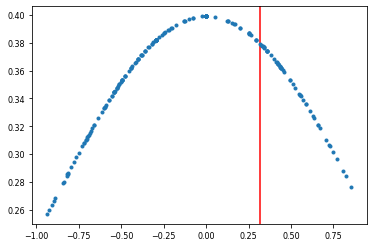

In [86]:
skewness(np.array(all_sentiments), "dados\\believes\\replies_238717783007977473.json")


Skewness for data :  -0.9210187291017764


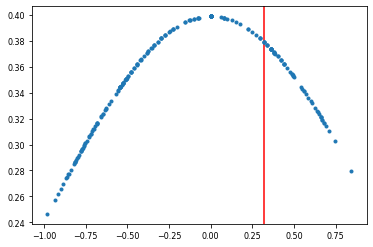

In [77]:
skewness(np.array(replies_sentiments), "dados\\believes\\replies_238717783007977473.json")

In [78]:
original = "dados\\believes\\replies_238717783007977473.json"

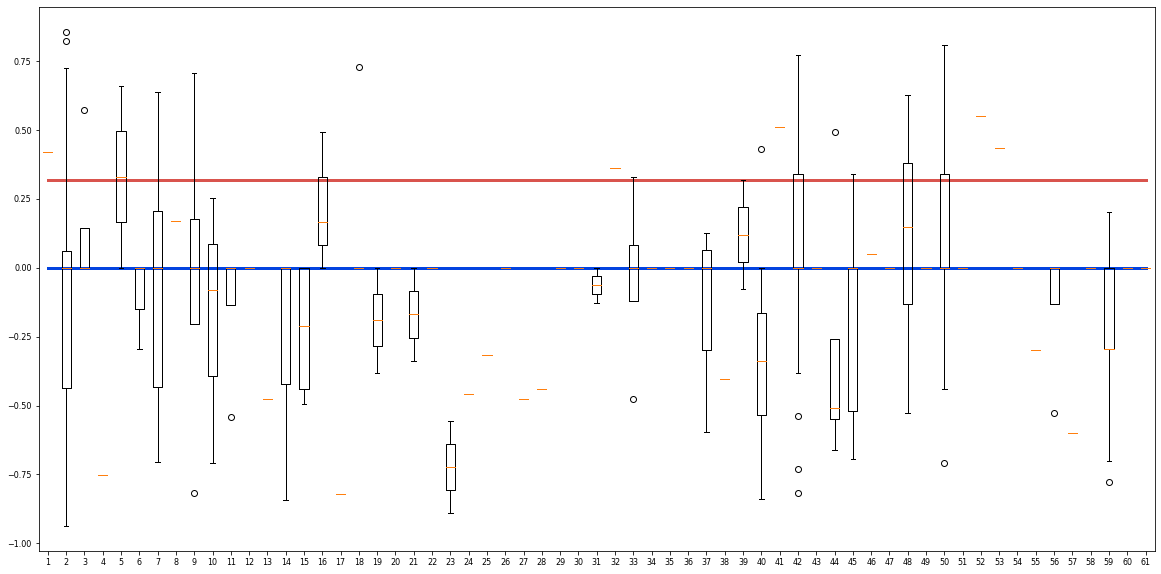

In [87]:
gen_boxplot(dist_sentiment.values(), "dist_sentiment.png", original)

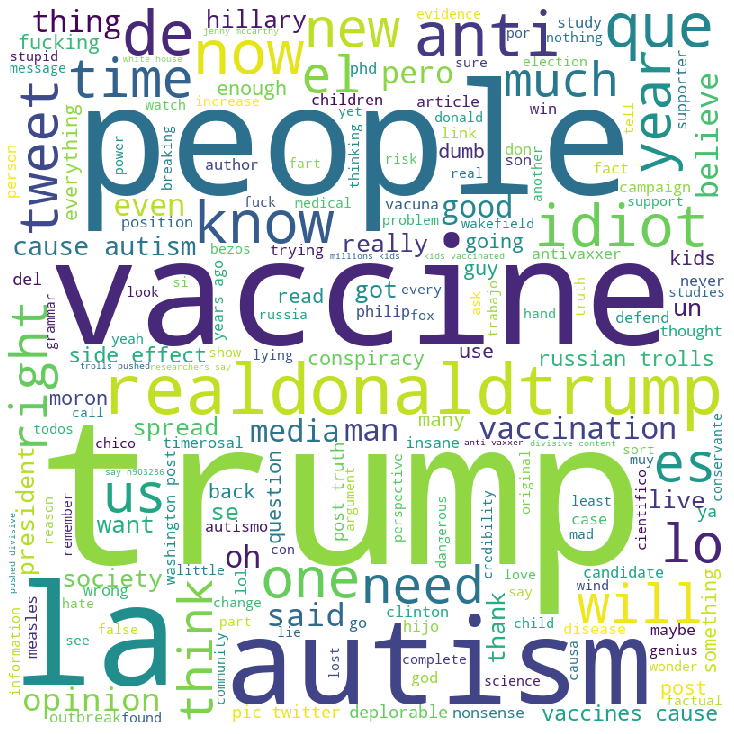

In [93]:
word_cloud(positives, "wordcloud_positives.png")

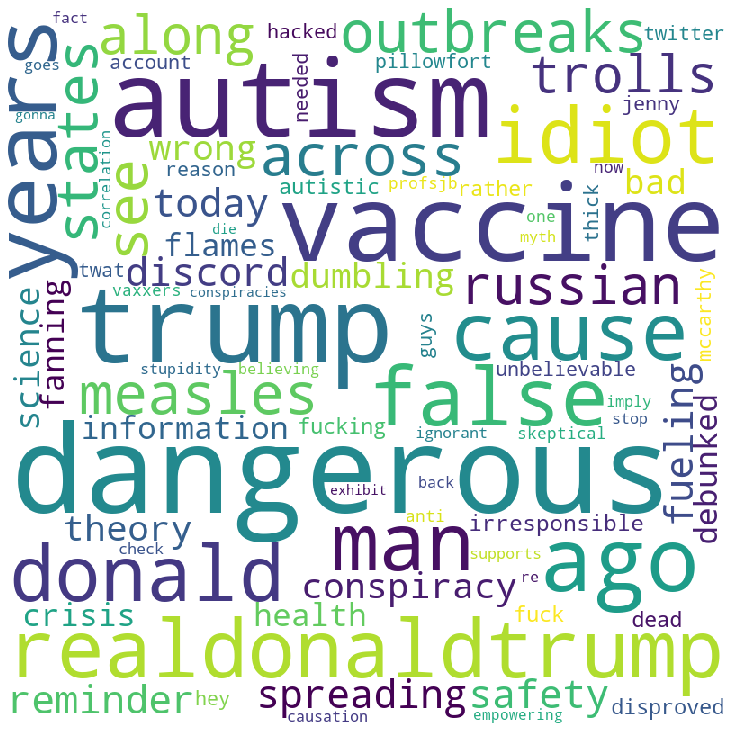

In [89]:
word_cloud(negatives, "wordcloud_negatives.png")